In [223]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [224]:
df = pd.read_csv('insurance_claims.csv')

### Data Exploration - Missing Values

In [225]:
df.head()
# Question mark in police_report_available.

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [227]:
def replace_question_marks(df):
    '''
    Replaces the question marks in the data set with blanks for visualization purposes.
    '''
    return df.replace(to_replace='?', value=np.nan)

In [229]:
def detailed_info(df):
    '''
    For visual purposes, creating a DataFrame to visualize different aspects for each column of data. Additionally, serves as easy reference for data exploration purposes.
    '''
    df = replace_question_marks(df)
    list_dtypes = []
    list_uniq = []
    list_nulls = []
    for col in df.columns:
        col_type = str(df[col].dtype)
        list_dtypes.append(col_type)
        list_uniq.append(df[col].nunique())
        list_nulls.append(df[col].isnull().sum())
    info = pd.DataFrame(data=np.array([list_dtypes, list_uniq, list_nulls]).T, columns=['Data Type', 'Unique Vals', 'Nulls'], index=df.columns)
    info['Column Name'] = info.index
    info.reset_index(inplace=True)
    return df, info.reindex(['Column Name', 'Data Type', 'Unique Vals', 'Nulls'], axis=1)

In [230]:
df, info_df = detailed_info(df)

In [231]:
info_df

,Column Name,Data Type,Unique Vals,Nulls
0,months_as_customer,int64,391,0
1,age,int64,46,0
2,policy_number,int64,1000,0
3,policy_bind_date,object,951,0
4,policy_state,object,3,0
5,policy_csl,object,3,0
6,policy_deductable,int64,3,0
7,policy_annual_premium,float64,991,0
8,umbrella_limit,int64,11,0
9,insured_zip,int64,995,0


In [250]:
def create_missing_vals_visual(df):
    '''
    Constructs a heatmap of the missing values for dataset.
    '''
    plt.rcParams['figure.dpi'] = 135
    plt.figure(figsize=(13, 8))
    g = sns.heatmap(df.isnull(), cmap='viridis', xticklabels=True, yticklabels=True)
    g.set_xlabel('Column Name')
    g.set_ylabel('Count of Missing Values')
    g.set_yticks([i for i in range(0, 1001, 50)])  # Set the y tick intervals
    g.set_yticklabels([str(i) for i in range(0, 1001, 50)])  # Attaches name to each y tick interval
    g.set_title('Heatmap of Missing Values')

    return g

<AxesSubplot:title={'center':'Heatmap of Missing Values'}, xlabel='Column Name', ylabel='Count of Missing Values'>

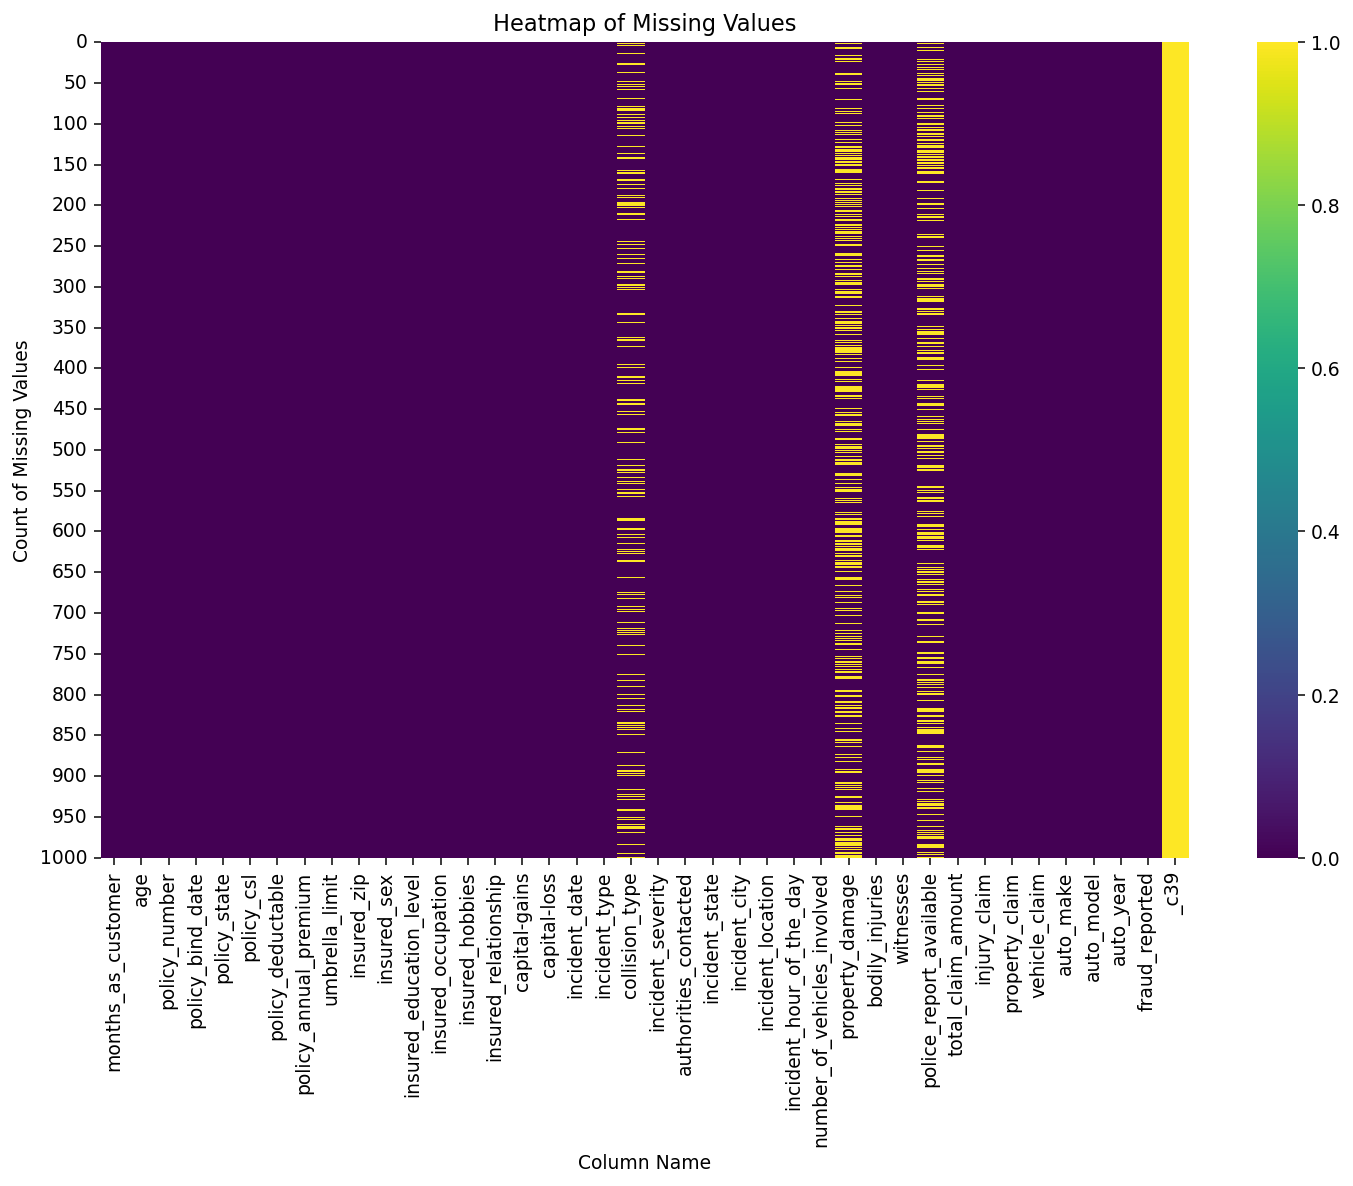

In [251]:
g = create_missing_vals_visual(df)
g

Ideally, do not drop the missing data. There are a total of 1000 columns and approximately 1/3 would be dropped for missing data (neglecting the _c39 data column which is completely empty).

In [245]:
df['collision_type'].value_counts()

Rear Collision     292
Side Collision     276
Front Collision    254
Name: collision_type, dtype: int64